In [1]:
import os
import requests
import datetime
from datetime import datetime, timedelta, timezone
import warnings
from tqdm import tqdm

# tar/zip related libs
import tarfile
import gzip
import shutil

from ease_grid import EASE2_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
from concurrent.futures import ThreadPoolExecutor

def generate_dates(start_date, end_date):
    current_date = start_date
    while current_date <= end_date:
        yield current_date
        current_date += datetime.timedelta(weeks=1)

def download_file(url, folder):
    local_filename = url.split('/')[-1]
    path = os.path.join(folder, local_filename)
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return local_filename

def download_files(urls, folder):
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_url = {executor.submit(download_file, url, folder): url for url in urls}
        for future in concurrent.futures.as_completed(future_to_url):
            url = future_to_url[future]
            try:
                future.result()
            except Exception as e:
                print(f"Failed to download {url}: {e}")

# Define the start and end dates
start_date = datetime.date(2020, 5, 25)
end_date = datetime.date(2020, 6, 2)

# Create a folder to store the downloaded files
folder = '/data/opensky_data'
os.makedirs(folder, exist_ok=True)

# Prepare a list of URLs to download
urls_to_download = []
for date in generate_dates(start_date, end_date):
    for hour in range(24):
        url = f"https://opensky-network.org/datasets/states/{date}/{str(hour).zfill(2)}/states_{date}-{str(hour).zfill(2)}.csv.tar"
        urls_to_download.append(url)

# Download files in parallel
download_files(urls_to_download, folder)

print("Download complete.")

TypeError: descriptor 'date' for 'datetime.datetime' objects doesn't apply to a 'int' object

In [ ]:
def extract_tar_files(tar_directory, gz_directory):
    # Create the gz directory if it doesn't exist
    if not os.path.exists(gz_directory):
        os.makedirs(gz_directory)

    # Loop through all files in the tar_directory
    for filename in os.listdir(tar_directory):
        if filename.endswith(".tar"):
            tar_path = os.path.join(tar_directory, filename)
            # Extract the .tar file
            with tarfile.open(tar_path) as tar:
                tar.extractall(path=tar_directory)

def decompress_gz_files(tar_directory, gz_directory):
    # Loop through all files in the tar_directory
    for filename in os.listdir(tar_directory):
        if filename.endswith(".gz"):
            gz_path = os.path.join(tar_directory, filename)
            # Decompress .gz file
            with gzip.open(gz_path, 'rb') as f_in:
                with open(os.path.join(gz_directory, filename[:-3]), 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            # Optional: Remove the .gz file after decompression
            os.remove(gz_path)

# Define your directories
tar_directory = '/Volumes/data/opensky_data/'
gz_directory = os.path.join(tar_directory, "gz")

# Extract tar files and then decompress gz files
extract_tar_files(tar_directory, gz_directory)
decompress_gz_files(tar_directory, gz_directory)

print("Extraction and decompression complete.")

In [3]:
# Path to the "gz" folder containing CSV files
gz_folder_path = '/Users/hyunglokkim/cpuserver_data/gz'
#gz_folder_path = '/data/gz'

# Initialize lists to store latitude, longitude, and time values
latitudes = []
longitudes = []
times = []

# Get the list of all files in the directory
files = [f for f in os.listdir(gz_folder_path) if f.endswith('.csv')]
total_files = len(files)

In [4]:
def set_egrid(resolution):
    if resolution == 'EASE2_3km':
        egrid = 3000
    elif resolution == 'EASE2_9km':
        egrid = 9000
    elif resolution == 'EASE2_12.5km':
        egrid = 12500
    elif resolution == 'EASE2_25km':
        egrid = 25000
    elif resolution == 'EASE2_36km':
        egrid = 36000
    else:
        egrid = None  # or some default value, or raise an error
    return egrid

In [8]:
# Define the region of interest (either "Korea" or "globe")
region = "Korea"  # Change this to "globe" to use all lat/lon data
# Select the resolution
resolution = 'EASE2_3km'  # Change this to select a different resolution

egrid =EASE2_grid(set_egrid(resolution))

# Korean Peninsula coordinates (if needed)
lat_min, lat_max = 33, 43
lon_min, lon_max = 124, 131

lons_2d, lats_2d = np.meshgrid(egrid.londim, egrid.latdim)

# If the region is "Korea", calculate the indices for the area of interest
if region == "Korea":
    lat_indices = np.where((lats_2d >= lat_min) & (lats_2d <= lat_max))
    lon_indices = np.where((lons_2d >= lon_min) & (lons_2d <= lon_max))

    # Use the indices to create cropped latitude and longitude arrays
    cropped_lats_2d = lats_2d[lat_indices[0][0]:lat_indices[0][-1] + 1, lon_indices[1][0]:lon_indices[1][-1] + 1]
    cropped_lons_2d = lons_2d[lat_indices[0][0]:lat_indices[0][-1] + 1, lon_indices[1][0]:lon_indices[1][-1] + 1]

# Path to the "gz" folder containing CSV files
files = sorted([f for f in os.listdir(gz_folder_path) if f.endswith('.csv')])

# Extract timestamps from file names and sort them
timestamps = [datetime.strptime(f.split('_')[1].split('.')[0], '%Y-%m-%d-%H') for f in files]
timestamps.sort()

# Calculate the range of timestamps
earliest_timestamp = timestamps[0]
latest_timestamp = timestamps[-1]

# Calculate the total number of hours between the earliest and latest timestamp
total_hours = int((latest_timestamp - earliest_timestamp).total_seconds() / 3600) + 1

# 'x' is the total number of unique hourly layers
x = total_hours

# Create the number_of_flights array with dynamic shape
number_of_flights = np.zeros((cropped_lats_2d.shape[0], cropped_lats_2d.shape[1], x), dtype=np.int8)

# Print the array shape and the range of dates
print(f"Array shape: {number_of_flights.shape}")
print(f"Time range: {earliest_timestamp} to {latest_timestamp}")

# Function to find the closest index in the grid for a given latitude or longitude
def find_closest_index(value, grid):
    return np.abs(grid - value).argmin()
    
# Turn off DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize the progress bar
pbar = tqdm(total=len(files), desc="Processing files")

for file in files[:1500]:
    file_path = os.path.join(gz_folder_path, file)
    df = pd.read_csv(file_path)

    # Filter out rows where latitude or longitude is outside the specified range
    if region == "Korea":
        df = df[(df['lat'] >= lat_min) & (df['lat'] <= lat_max) & (df['lon'] >= lon_min) & (df['lon'] <= lon_max)]

    # Check if the filtered DataFrame is not empty
    if not df.empty:
        for index, row in df.iterrows():
            # Find the closest grid cell in the cropped 2D grid
            grid_lat_idx = find_closest_index(row['lat'], cropped_lats_2d[:, 0])
            grid_lon_idx = find_closest_index(row['lon'], cropped_lons_2d[0, :])

            # Calculate the hourly layer index based on time
            time = datetime.utcfromtimestamp(row['time'])
            hourly_layer_idx = int((time - earliest_timestamp).total_seconds() / 3600)

            # Increment the count in the corresponding cell
            number_of_flights[grid_lat_idx, grid_lon_idx, hourly_layer_idx] += 1

        # Update the progress bar for each file
        pbar.update(1)

# Close the progress bar after processing all files
pbar.close()

Array shape: (336, 225, 18336)
Time range: 2020-05-25 00:00:00 to 2022-06-27 23:00:00


Processing files:  61%|███████████▌       | 1500/2462 [1:02:04<39:48,  2.48s/it]


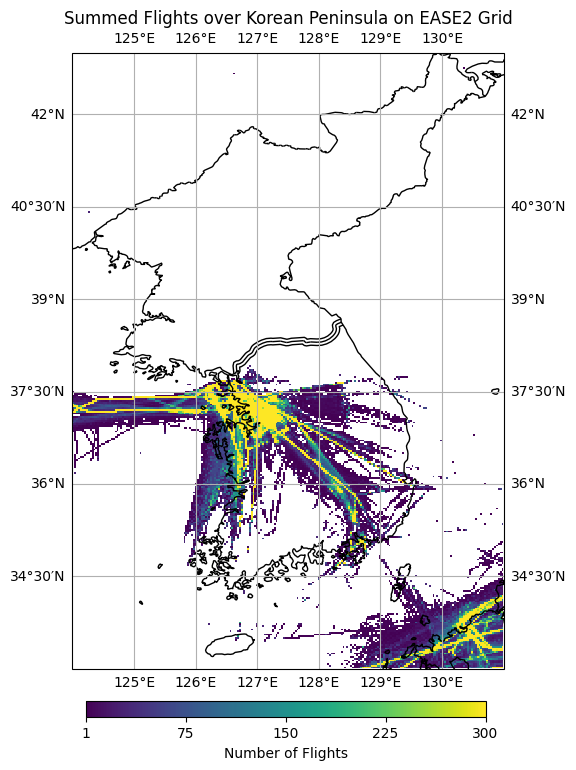

In [7]:
summed_flights = np.sum(number_of_flights,2).astype('float64')
summed_flights[summed_flights <= 0 ] = np.nan
summed_flights[summed_flights > 300] = 300

# Plotting
fig = plt.figure(figsize=(10, 8))

# Define the map projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set the extent to the Korean Peninsula
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.coastlines()

# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Create the mesh plot using cropped_lons_2d and cropped_lats_2d
mesh = plt.pcolormesh(cropped_lons_2d, cropped_lats_2d, summed_flights, shading='auto', transform=ccrs.PlateCarree())

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Summed Flights over Korean Peninsula on EASE2 Grid')

# Define the position and size of the color bar manually
cbar_axes = fig.add_axes([0.31, 0.05, 0.4, 0.02])  # [left, bottom, width, height]

# Add the color bar
cbar = plt.colorbar(mesh, cax=cbar_axes, orientation='horizontal')

# Get the minimum and maximum of summed_flights for the color bar ticks
min_val, max_val = np.nanmin(summed_flights), np.nanmax(summed_flights)

# Create 5 evenly spaced ticks from min_val to max_val
# Ensure that the minimum tick starts from 1
ticks = np.linspace(max(min_val, 1), max_val, 5)

# Set ticks and tick labels
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(tick)}" for tick in ticks])

# Set the color bar label
cbar.set_label('Number of Flights')

plt.show()

In [ ]:
np.min(summed_flights)

In [ ]:
# Adjust the dtype and shape according to your data's specification
lon_shape = (406, 964) # replace with actual dimensions of longitude data
lat_shape = (406, 964) # replace with actual dimensions of latitude data

lons = np.fromfile('/data/EASE2/EASE2_M36km.lons.964x406x1.double', dtype=np.double)
lats = np.fromfile('/data/EASE2/EASE2_M36km.lats.964x406x1.double', dtype=np.double)

lons = lons.reshape(lon_shape)
lats = lats.reshape(lat_shape)

# Create an array of NaN values
data = np.full(lon_shape, np.nan).squeeze()

In [ ]:
def interpolate_edges(arr):
    # Interpolate between points to approximate the edges
    arr_expanded = np.zeros((arr.shape[0]+1, arr.shape[1]+1))
    arr_expanded[1:-1, 1:-1] = (arr[:-1, :-1] + arr[1:, :-1] + arr[:-1, 1:] + arr[1:, 1:]) / 4
    arr_expanded[0, 1:-1] = (arr[0, :-1] + arr[0, 1:]) / 2
    arr_expanded[-1, 1:-1] = (arr[-1, :-1] + arr[-1, 1:]) / 2
    arr_expanded[1:-1, 0] = (arr[:-1, 0] + arr[1:, 0]) / 2
    arr_expanded[1:-1, -1] = (arr[:-1, -1] + arr[1:, -1]) / 2
    arr_expanded[0, 0] = arr[0, 0]
    arr_expanded[-1, -1] = arr[-1, -1]
    arr_expanded[0, -1] = arr[0, -1]
    arr_expanded[-1, 0] = arr[-1, 0]
    return arr_expanded

lons_edges = interpolate_edges(lons)
lats_edges = interpolate_edges(lats)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([124, 132, 33, 43], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='none')

# Plotting the approximate grid edges
for i in range(lons_edges.shape[0]):
    ax.plot(lons_edges[i, :], lats_edges[i, :], color='black', alpha=0.5, linewidth=0.5, transform=ccrs.Geodetic())

for i in range(lats_edges.shape[1]):
    ax.plot(lons_edges[:, i], lats_edges[:, i], color='black', alpha=0.5, linewidth=0.5, transform=ccrs.Geodetic())

plt.title("Approximate EASE-Grid Edges Visualization over the Korean Peninsula")
plt.show()

In [ ]:
# Dictionary to map resolutions to their grid sizes and file names
grid_info = {
    'EASE2_3km': {'lat_size': 4872, 'lon_size': 11568, 'lon_file': 'EASE2_M03km.lons.11568x4872x1.double', 'lat_file': 'EASE2_M03km.lats.11568x4872x1.double'},
    'EASE2_9km': {'lat_size': 1624, 'lon_size': 3856, 'lon_file': 'EASE2_M09km.lons.3856x1624x1.double', 'lat_file': 'EASE2_M09km.lats.3856x1624x1.double'},
    'EASE2_12.5km': {'lat_size': 1168, 'lon_size': 2776, 'lon_file': 'EASE2_M12.5km.lons.2776x1168x1.double', 'lat_file': 'EASE2_M12.5km.lats.2776x1168x1.double'},
    'EASE2_25km': {'lat_size': 584, 'lon_size': 1388, 'lon_file': 'EASE2_M25km.lons.1388x584x1.double', 'lat_file': 'EASE2_M25km.lats.1388x584x1.double'},
    'EASE2_36km': {'lat_size': 406, 'lon_size': 964, 'lon_file': 'EASE2_M36km.lons.964x406x1.double', 'lat_file': 'EASE2_M36km.lats.964x406x1.double'}
}j

# Set the grid-related variables based on the selected resolution
lat_size = grid_info[resolution]['lat_size']
lon_size = grid_info[resolution]['lon_size']
lon_file = grid_info[resolution]['lon_file']
lat_file = grid_info[resolution]['lat_file']

# Read EASE2 grid values
lons_1d = np.fromfile(f'/data/EASE2/{lon_file}', dtype=np.double)
lats_1d = np.fromfile(f'/data/EASE2/{lat_file}', dtype=np.double)

# Reshape the 1D arrays to 2D grids
lons_2d = lons_1d.reshape((lat_size, lon_size))
lats_2d = lats_1d.reshape((lat_size, lon_size))
